<center><h1>Convolutional Neural Networks (CNN)</h1></center>

<center><h2><a href="https://deepcourse-epita.netlify.app/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

If you find a mistake, or know how to improve this notebook, please open an issue [here](https://gitlab.com/ey_datakalab/course_epita).

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [7]:
import time

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import pandas as pd
import os
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [4]:
import zipfile
with zipfile.ZipFile("landmark.zip", 'r') as zip_ref:
    zip_ref.extractall("./landmark")

In [5]:
with zipfile.ZipFile("aligned.zip", 'r') as zip_ref:
    zip_ref.extractall("./aligned")

In [6]:
import csv
# Creation des labels sous formats csv

with open("list_patition_label.txt","r") as file :
    with open("list_label.csv","w",newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Filename", "Label"])
        for line in file:
            filename, label = line.strip().split(" ")
            writer.writerow([filename, label])

In [8]:
with open("list_patition_label.txt", "r") as f:
    lines = f.readlines()

# Initialize empty lists for test and train data
test_data = []
train_data = []

# Iterate over the lines
for line in lines:
    filename, label = line.strip().split(" ")
    if filename.startswith("test_"):
        test_data.append([filename, label])
    elif filename.startswith("train_"):
        train_data.append([filename, label])

test_df = pd.DataFrame(test_data, columns=["filename", "label"])
train_df = pd.DataFrame(train_data, columns=["filename", "label"])

# Write data to CSV files
test_df.to_csv("test_labels.csv", index=False)
train_df.to_csv("train_labels.csv", index=False)

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
data = CustomImageDataset("list_label.csv","./aligned") #Test et train melanger faut que je les separe avant
data_loader = DataLoader(data, batch_size=32, shuffle=True, num_workers=4)
print(f"\nNb batches in train: {len(data_loader)}")



Nb batches in train: 480


In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        test_img_paths = []
        train_img_paths = []

        for i in range(len(self.img_labels)):
            img_path = os.path.join(self.img_dir, self.img_labels.iloc[i, 0])
            test_img_path = os.path.join(self.img_dir, 'test', self.img_labels.iloc[i, 0])
            train_img_path = os.path.join(self.img_dir, 'train', self.img_labels.iloc[i, 0])
            if os.path.exists(test_img_path):
                test_img_paths.append(test_img_path)
            elif os.path.exists(train_img_path):
                train_img_paths.append(train_img_path)

        self.test_img_labels = self.img_labels[self.img_labels['filename'].isin(test_img_paths)]
        self.train_img_labels = self.img_labels[self.img_labels['filename'].isin(train_img_paths)]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
test_dataset = CustomImageDataset("test_labels.csv", "./aligned")
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
train_dataset = CustomImageDataset("train_labels.csv", "./aligned")
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4)
print(f"\nNb batches in train: {len(train_data_loader)}")
print(f"Nb batches in test: {len(test_data_loader)}")


Nb batches in train: 384
Nb batches in test: 96


In [7]:
pwd = %pwd
cifar_mean = torch.tensor([0.5071, 0.4867, 0.4408])
cifar_std = torch.tensor([0.2675, 0.2565, 0.2761])

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),                            
])


train_dataset = CIFAR10(pwd + "/temp", download=True, train=True, transform=train_transforms)
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, 
    [int(0.8 * len(train_dataset)), int(0.2 * len(train_dataset))]
  )
val_dataset.transform = test_transforms
test_dataset = CIFAR10(pwd + "/temp", download=False, train=False, transform=test_transforms)

print(f"Nb images in train: {len(train_dataset)}")
print(f"Nb images in val: {len(val_dataset)}")
print(f"Nb images in test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=512, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=512, num_workers=2)

print(f"\nNb batches in train: {len(train_loader)}")
print(f"Nb batches in val: {len(val_loader)}")
print(f"Nb batches in test: {len(test_loader)}")

Files already downloaded and verified
Nb images in train: 40000
Nb images in val: 10000
Nb images in test: 10000

Nb batches in train: 157
Nb batches in val: 20
Nb batches in test: 20


torch.Size([256, 3, 32, 32]) torch.Size([256])
tensor(-1.8975) tensor(2.0254)
tensor([1, 4, 6, 3, 8, 2, 9, 2, 6, 4])


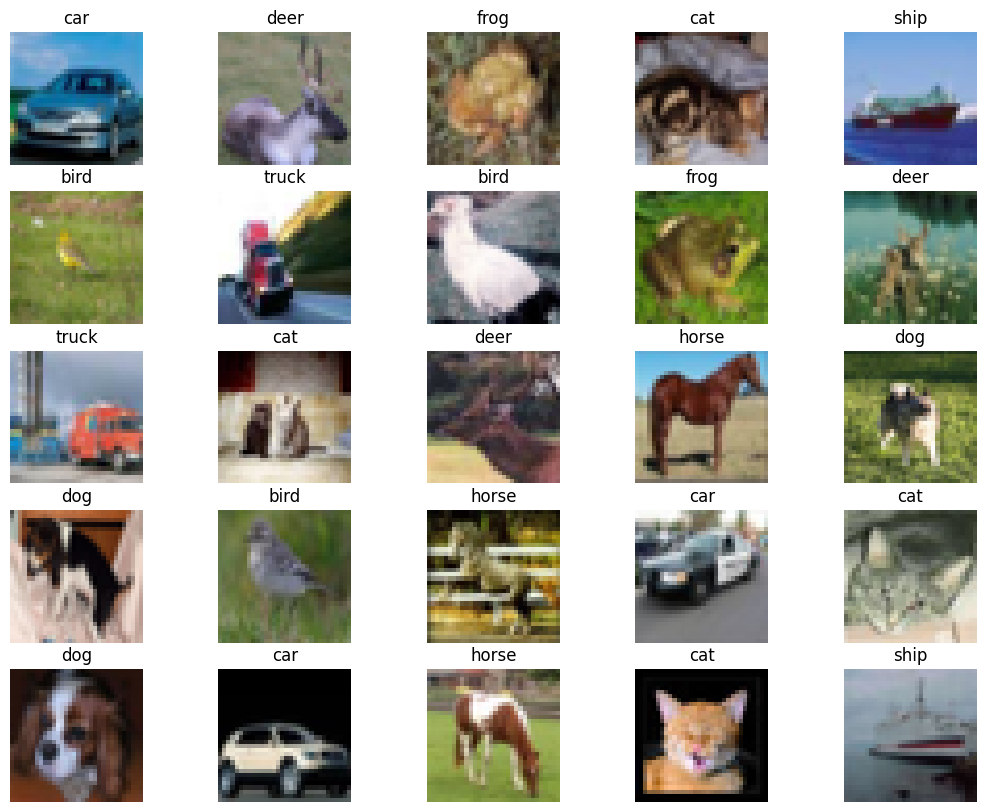

In [8]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)
print(x.min(), x.max())
print(y[:10])

classes = [
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

plt.figure(figsize=(13, 10))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  img = x[i]
  img = img * cifar_std[:, None, None] + cifar_mean[:, None, None]  # Denormalize
  img = img.permute(1, 2, 0)  # move channel at last dimension
  img = np.clip(255 * img.numpy(), a_min=0, a_max=255).astype(np.uint8)
  img = Image.fromarray(img)
  plt.imshow(img)
  plt.axis('off')
  plt.title(classes[y[i]])

In [ ]:

import torch
import torch.nn as nn


class Vgg(nn.Module):

    def __init__(self):
        super(Vgg, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=2622, bias=True)

    def forward(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        return x38

def vgg_face(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [9]:
def eval_model(net, loader, loss_fn):
  net.eval()
  acc, loss = 0., 0.
  c = 0
  for x, y in loader:
    with torch.no_grad():
      # No need to compute gradient here thus we avoid storing intermediary activations
      logits = net(x.to(device)).cpu()

    loss += loss_fn(logits, y).item()
    preds = logits.argmax(dim=1)
    acc += (preds.numpy() == y.numpy()).sum()
    c += len(x)

  acc /= c
  loss /= len(loader)
  net.train()
  return acc, loss

In [ ]:
net = CNN().to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=0.1)#, momentum=0.9, nesterov=True)
cross_entropy = nn.CrossEntropyLoss()  # Does softmax+CE

nb_epochs = 20

train_accs, train_losses = [], []
val_accs, val_losses = [], []

initial_acc, initial_loss = eval_model(net, val_loader, cross_entropy)
print(f"Initial accuracy/loss on val: {round(100 * initial_acc, 2)}/{round(initial_loss, 4)}")

for epoch in range(nb_epochs):
  start = time.time()
  running_acc, running_loss = 0., 0.
  c = 0
  for x, y in train_loader:
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()  # Clear previous gradients
    logits = net(x)
    loss = cross_entropy(logits, y)
    loss.backward()  # Compute gradients
    optimizer.step()  # Update weights with gradients

    running_acc += (logits.argmax(dim=1).cpu().numpy() == y.cpu().numpy()).sum()
    running_loss += loss.item()
    c += len(x)

  train_acc, train_loss = running_acc / c, running_loss / len(train_loader)
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  
  val_acc, val_loss = eval_model(net, val_loader, cross_entropy)
  val_accs.append(val_acc)
  val_losses.append(val_loss)

  print(
      f"Epoch {epoch + 1}/{nb_epochs}, "
      f"train acc/loss: {round(100 * train_acc, 2)}/{round(train_loss, 4)}, "
      f"val acc/loss: {round(100 * val_acc, 2)}/{round(val_loss, 4)}, "
      f"time {int(time.time() - start)}s"
  )

Initial accuracy/loss on val: 8.5/2.3037
Epoch 1/20, train acc/loss: 27.52/1.9937, val acc/loss: 32.28/1.9705, time 32s
Epoch 2/20, train acc/loss: 42.66/1.5944, val acc/loss: 47.04/1.4815, time 32s
Epoch 3/20, train acc/loss: 49.9/1.404, val acc/loss: 47.63/1.4451, time 33s
Epoch 4/20, train acc/loss: 55.09/1.2662, val acc/loss: 46.22/1.4739, time 33s
Epoch 5/20, train acc/loss: 59.81/1.1381, val acc/loss: 49.19/1.4244, time 33s
Epoch 6/20, train acc/loss: 63.92/1.0309, val acc/loss: 55.82/1.2844, time 33s
Epoch 7/20, train acc/loss: 66.96/0.9429, val acc/loss: 61.56/1.0927, time 34s
Epoch 8/20, train acc/loss: 70.51/0.8482, val acc/loss: 62.2/1.1218, time 39s


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(list(range(nb_epochs)), train_accs, label="Train")
plt.plot(list(range(nb_epochs)), val_accs, label="Val")
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(list(range(nb_epochs)), train_losses, label="Train")
plt.plot(list(range(nb_epochs)), val_losses, label="Val")
plt.title("Loss")

Now that our model has trained, let's check the final test performance:

In [ ]:
test_acc, test_loss = eval_model(net, test_loader, cross_entropy)
test_acc, test_loss